## Analisis de Datos Aplicables al Teorema de Naive Bayes

# 1. Dataset
Una compañía de seguros médicos ha publicado datos de casi 1.000 clientes. Cree un modelo que prediga el costo de la cobertura médica anual. 
Los datos son proporcionados voluntariamente por los clientes.

- target = Charged
- features = Age, Sex, BMI, Children, Smoker, Region

In [35]:
# importamos las Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [20]:
data = pd.read_csv('insurance.csv')
print(f"shape: {data.shape}")
data.head()

shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Visualizacion de Dataset

In [21]:
df = pd.DataFrame(data)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 3. Preparacion del Dataset

In [23]:
df.isnull().sum().to_frame('NaN value').T

,age,sex,bmi,children,smoker,region,charges
NaN value,0,0,0,0,0,0,0


In [24]:
for col in df:
    print(f"{col}: {df[col].nunique()}")

age: 47
sex: 2
bmi: 548
children: 6
smoker: 2
region: 4
charges: 1337


In [25]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [26]:
df.describe(include=[object]).T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [27]:
df.drop('age', axis=1, inplace=True)
df

,sex,bmi,children,smoker,region,charges
0,female,27.900,0,yes,southwest,16884.92400
1,male,33.770,1,no,southeast,1725.55230
2,male,33.000,3,no,southeast,4449.46200
3,male,22.705,0,no,northwest,21984.47061
4,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...
1333,male,30.970,3,no,northwest,10600.54830
1334,female,31.920,0,no,northeast,2205.98080
1335,female,36.850,0,no,southeast,1629.83350
1336,female,25.800,0,no,southwest,2007.94500


In [28]:
df['sex'] = df['sex'].replace(['male', 'female'], [0, 1])
df

,sex,bmi,children,smoker,region,charges
0,1,27.900,0,yes,southwest,16884.92400
1,0,33.770,1,no,southeast,1725.55230
2,0,33.000,3,no,southeast,4449.46200
3,0,22.705,0,no,northwest,21984.47061
4,0,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...
1333,0,30.970,3,no,northwest,10600.54830
1334,1,31.920,0,no,northeast,2205.98080
1335,1,36.850,0,no,southeast,1629.83350
1336,1,25.800,0,no,southwest,2007.94500


## 4. Analisis Exploratorio de Datos

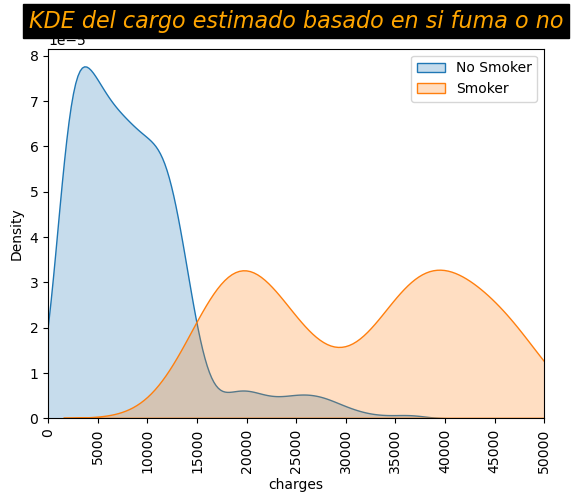

In [29]:
# Revisar la distribucion de cargos (basado en si la persona fuma)
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore", category = FutureWarning)
font = {'fontsize': 16, 'fontstyle': 'italic', 'backgroundcolor': 'black', 'color': 'orange'}

%matplotlib inline
sns.kdeplot(df.loc[df['smoker'] == 'no', 'charges'], label='No Smoker', fill=True)
sns.kdeplot(df.loc[df['smoker'] == 'yes', 'charges'], label='Smoker', fill=True)
plt.title('KDE del cargo estimado basado en si fuma o no', fontdict=font, pad=15)
plt.xticks(np.arange(0, 50001, 5000), rotation=90)
plt.xlim([0, 50001])
plt.legend()
plt.show()


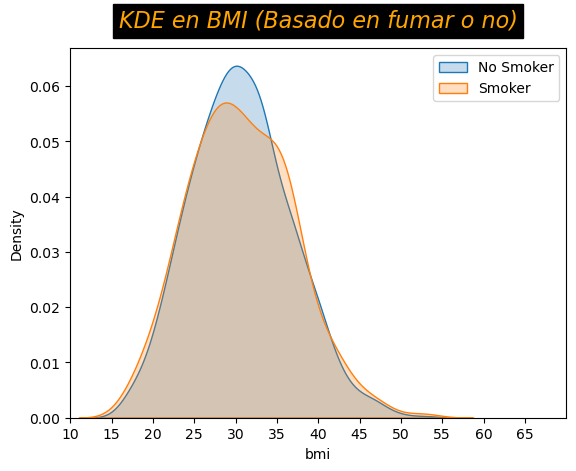

In [30]:
%matplotlib inline
sns.kdeplot(df.loc[df['smoker'] == 'no', 'bmi'], label='No Smoker', fill=True)
sns.kdeplot(df.loc[df['smoker'] == 'yes', 'bmi'], label='Smoker', fill=True)
plt.title('KDE en BMI (Basado en fumar o no)', fontdict=font, pad=15)
plt.xticks(np.arange(0, 70, 5))
plt.xlim([10, 70])
plt.legend()
plt.show()

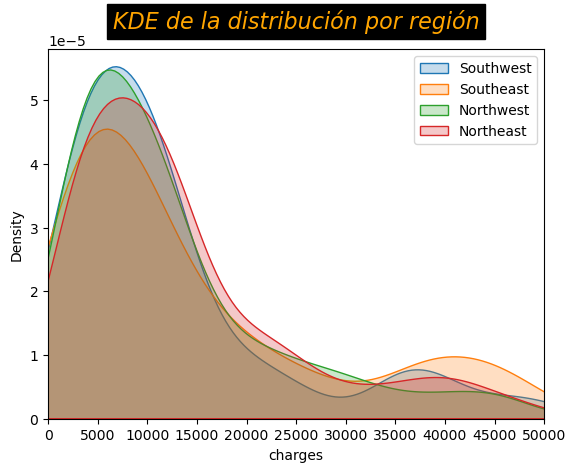

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
font = {'fontsize': 16, 'fontstyle': 'italic', 'backgroundcolor': 'black', 'color': 'orange'}
%matplotlib inline
sns.kdeplot(df.loc[df['region'] == 'southwest', 'charges'], label='Southwest', fill=True)
sns.kdeplot(df.loc[df['region'] == 'southeast', 'charges'], label='Southeast', fill=True)
sns.kdeplot(df.loc[df['region'] == 'northwest', 'charges'], label='Northwest', fill=True)
sns.kdeplot(df.loc[df['region'] == 'northeast', 'charges'], label='Northeast', fill=True)
plt.title('KDE de la distribución por región', fontdict=font, pad=15)
plt.xticks(np.arange(0, 50001, 5000))
plt.xlim([0, 50001])
plt.legend()
plt.show()

De acuerdo con los KDE plots tenemos que:

- La mayoría de las personas no fumadoras tienden a concentrarse en edades jóvenes, alrededor de los 20 a 40 años.
- Las distribuciones de género no difieren significativamente en cuanto a la edad de los individuos.
- En la región suroeste, la mayoría de las personas son jóvenes (20-35 años), mientras que en las regiones noreste y noroeste hay una presencia de personas de mayor edad (50+ años).
- La diferencia de edad según la región muestra que algunas regiones tienen una población más joven (suroeste) y otras regiones tienen personas de mayor edad (noreste y noroeste)

## 4.1 Analisis Univariable

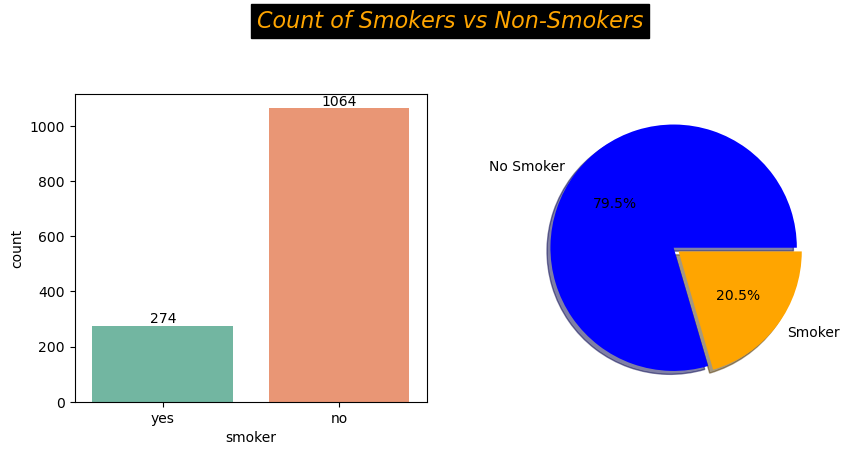

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(data=df, x='smoker', ax=axes[0], palette='Set2')
for container in axes[0].containers:
    axes[0].bar_label(container)
slices = df.smoker.value_counts().values
activities = ['No Smoker', 'Smoker']
axes[1].pie(slices, labels=activities, colors=['blue', 'orange'], shadow=True, explode=[0, 0.05], autopct='%1.1f%%')
plt.suptitle('Count of Smokers vs Non-Smokers', y=1.09, **font)
plt.show()

## 4.2 Analisis Bivariable

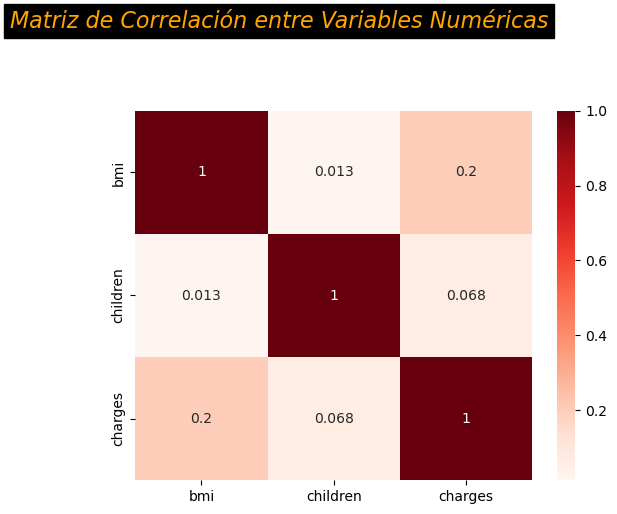

In [33]:
numeric_columns = df[['bmi', 'children', 'charges']]
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, cmap='Reds', annot=True)
plt.suptitle('Matriz de Correlación entre Variables Numéricas', y=1.09, x=0.35, **font)
plt.show()

## 4.3 Analisis Multivariable

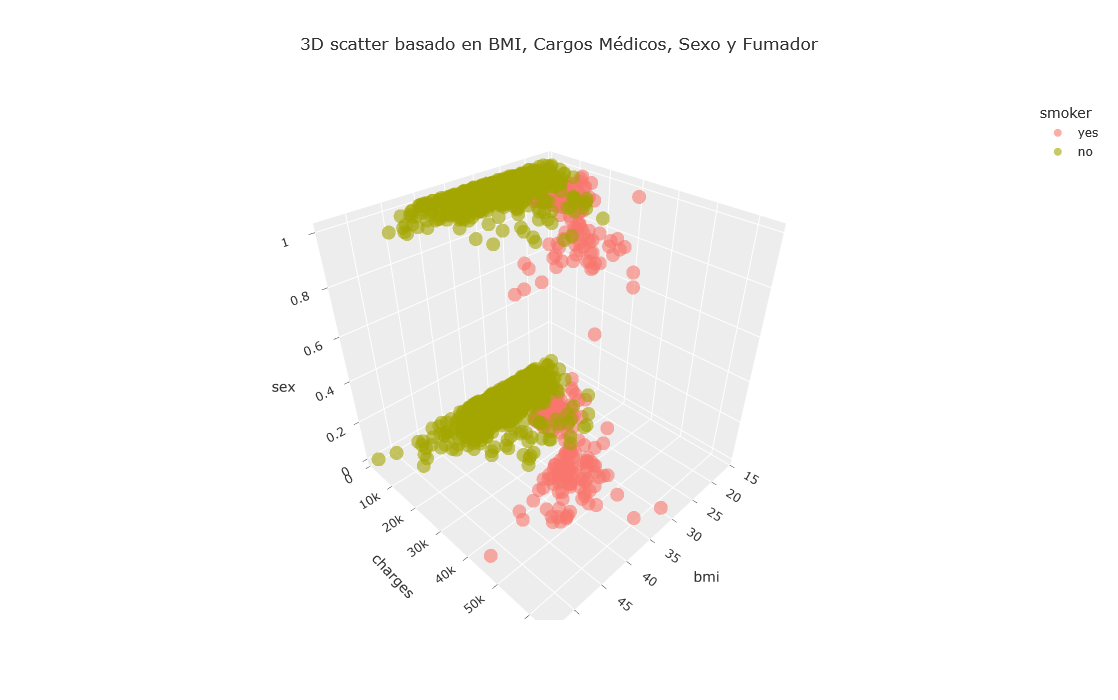

In [34]:
fig = px.scatter_3d(
    data_frame=df,
    x='bmi',
    y='charges',
    z='sex',
    color='smoker',
    template='ggplot2',
    opacity=0.6,
    height=700,
    title=f'3D scatter basado en BMI, Cargos Médicos, Sexo y Fumador'
)

pio.show(fig)